## Extract true signal from background noise using clustering algorithms

In this notebook we show how signal classification is done in qibocal for flux_dependence protocols.
I this protocols we deal with a 2D signal, which corresponds to different spectroscopies (either qubit or resonator) for different DC flux biases.

In [4]:
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
from scipy.signal import find_peaks
from sklearn.cluster import HDBSCAN

In [5]:
def plot_function(
    complete_signal,
    x_scale: tuple,
    y_scale: tuple,
    extracted_signal: Optional = None,
    classes_labels=None,
):
    plt.imshow(
        complete_signal,
        origin="lower",
        aspect="auto",
        extent=[
            np.round(x_scale[0], 3),
            np.round(x_scale[-1], 3),
            y_scale[0],
            y_scale[-1],
        ],
    )
    plt.colorbar()
    plt.xlabel("Frequency  (Hz)")
    plt.ylabel("Flux Bias  (a.u.)")

    if extracted_signal is not None:
        plt.scatter(
            extracted_signal[0],
            extracted_signal[1],
            c=classes_labels if classes_labels is not None else "r",
            cmap=classes_labels if classes_labels is None else "Paired",
            lw=1,
            ec="k",
            s=20,
        )
    plt.show()


def plot_3d_scatter(x, y, z, sig):
    plt.clf()

    # Make data
    X = np.arange(sig.shape[1])
    Y = np.arange(sig.shape[0])
    X, Y = np.meshgrid(X, Y)

    # Plot the surface
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
    ax.scatter(x, y, z)
    ax.set_xlabel("Frequency  (GHz)")
    ax.set_ylabel("Flux Bias  (a.u.)")
    ax.set_zlabel("Signal Magnitude (a.u.)")

    plt.show()

here we load a dataset from an actual qubit_flux qibocal experiment performed on QPU qw21q-b

In [ ]:
# datafile = "./notebook_data/ResonatorFlux/data/resonator_flux-3/data.npz"
# datafile = "./notebook_data/QubitFlux/data/qubit_flux-0/data.npz"
datafile = "./notebook_data/ResonatorPunchout/data/resonator_punchout-0/data.npz"
data = np.load(datafile)
keys_list = list(data.keys())
a = data[keys_list[0]]
print(a)
b = a["amp"]
f = a["freq"]
sig = a["signal"]
unique_freq = np.unique(f)
unique_bias = np.unique(b)
s = a["signal"].reshape(unique_bias.size, unique_freq.size)

find_min_peak = True if "ResonatorFlux" in datafile else False

[(4.99256953e+09, -0.06857685, 0.00527054)
 (4.99296953e+09, -0.06857685, 0.00524298)
 (4.99336953e+09, -0.06857685, 0.0051022 ) ...
 (5.00656953e+09,  0.03042315, 0.00516712)
 (5.00696953e+09,  0.03042315, 0.00536566)
 (5.00736953e+09,  0.03042315, 0.00505131)]


ValueError: no field of name amp

we expect the signal to be something like:

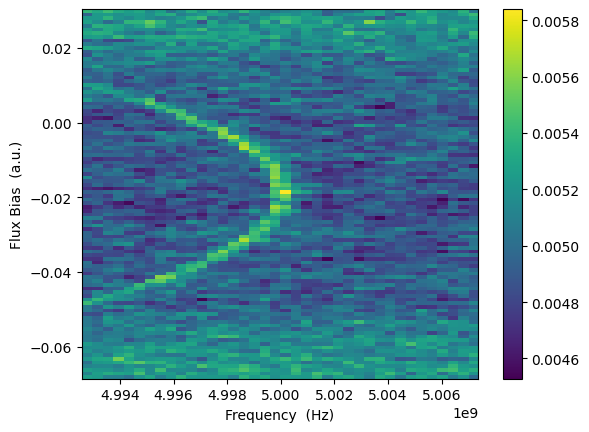

In [40]:
plot_function(s, unique_freq, unique_bias)

where it is clear the signal we want to extract (parabola-shape curve);

for some pathological cases (such as this one), where the SNR is not big enough, find_peaks fails to identify the peaks and hence the signal.

So we need to implement a more sophisticated procedure, such as the one described below. 

The full routine is implemented in qibocal package and can be imported in the following way:

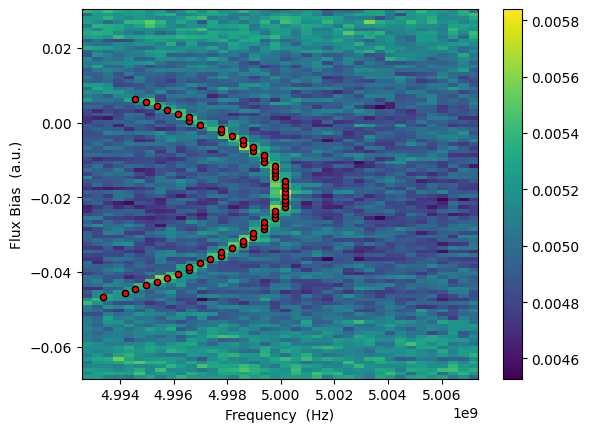

In [41]:
# from qibocal.protocols.utils import extract_feature
from notebook_utils import extract_feature

signal_x, signal_y = extract_feature(f, b, s, find_min_peak)
plot_function(s, unique_freq, unique_bias, (signal_x, signal_y))

The `extract_feature` method is designed to automatically identify the relevant signal in a 2D sweep dataset.
Starting from raw, noisy measurements, it progressively cleans the data, detects candidate signal points, and finally isolates the true signal using clustering.

The procedure is divided into three main stages:

1. Data preprocessing

2. Peak identification

3. Clustering and signal selection

This function is relevant for several protocols in qibocal, such as `qubit_flux`, `resonator_flux` or `qubit_crosstalk` experiments. 

During this notebook we will analyze step by step the protocol behind this routine.

# 1. Data Preprocessing

The first step of the method consists in filtering the input raw data in order to improve SNR.
Hence, a custom filtering procedure is applied in order to remove background gradients and suppress noise.

This filter consists of two following transformation of the whole data, namely a ZCA whitening first and then a Gaussian filter with unitary variance.

Finally, the filtered signal is normalized slice by slice along the flux bias direction using min–max normalization. 

In the following cells is shown the code structure for this preprocessing step.

In [ ]:
def scaling_slice(sig: np.ndarray, axis=int) -> np.ndarray:
    sig_min = np.min(sig, axis=1)
    return ((sig.T - sig_min) / (np.max(sig, axis=1) - sig_min)).T


def zca_whiten(X):
    """
    Applies ZCA whitening to the data (X)
    http://xcorr.net/2011/05/27/whiten-a-mfilters.gaussianatrix-matlab-code/

    X: numpy 2d array
        input data, rows are data points, columns are features

    Returns: ZCA whitened 2d array
    """
    assert X.ndim == 2
    EPS = 10e-5

    #   covariance matrix
    cov = np.dot(X.T, X)
    #   d = (lambda1, lambda2, ..., lambdaN)
    d, E = np.linalg.eigh(cov)
    #   D = diag(d) ^ (-1/2)
    D = np.diag(1.0 / np.sqrt(d + EPS))
    #   W_zca = E * D * E.T
    W = np.dot(np.dot(E, D), E.T)

    X_white = np.dot(X, W)

    return X_white


def custom_filter_mask(matrix_z: np.ndarray):
    """Applying a mask compsosed by first a ZCA transformation and then a gaussian filter with variance 1."""

    zca_z = zca_whiten(matrix_z)
    # adding zca filter for filtering out background noise gradient
    zca_gauss_z = ndimage.gaussian_filter(zca_z, 1)
    # adding gaussia fliter with unitary variance for blurring the signal and reducing noise

    return zca_gauss_z, zca_z


# DATA PREPROCESSING
# custom masking
s_masked, s_zca = custom_filter_mask(s)

s_masked = -s_masked if find_min_peak is True else s_masked

# renormalizing
s_masked_norm = scaling_slice(s_masked, axis=1)

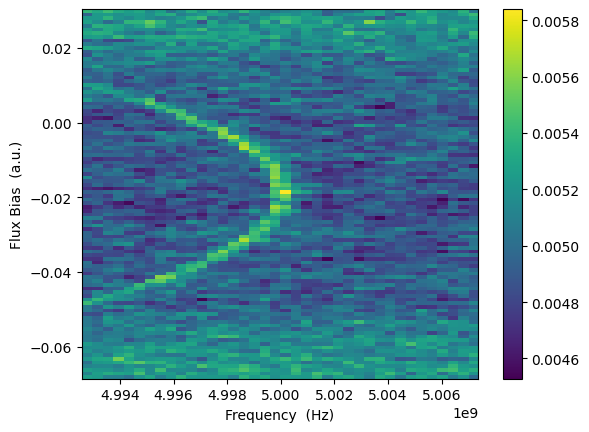

In [52]:
# plotting raw data
plot_function(s, unique_freq, unique_bias)

ZCA whitening, as it is possible to see in the cell below, decorrelates the data and strongly reduces slow spatial variations, specially noisy gradients in the background.
We see in this case in fact how the lower and upper region of the whole signal now have the same values as the whole background.

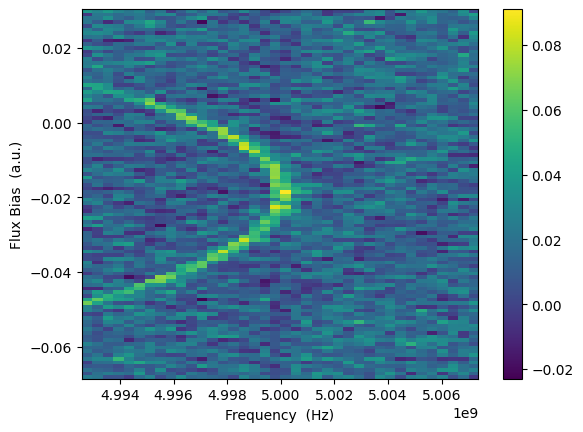

In [53]:
# plotting the filtered data with zca
plot_function(s_zca, unique_freq, unique_bias)

The applied Gaussian filter smooths high-frequency noise while preserving coherent structures such as ridges or valleys in the signal. 

The resulting matrix represents a cleaned version of the original data, where relevant features are more clearly visible.

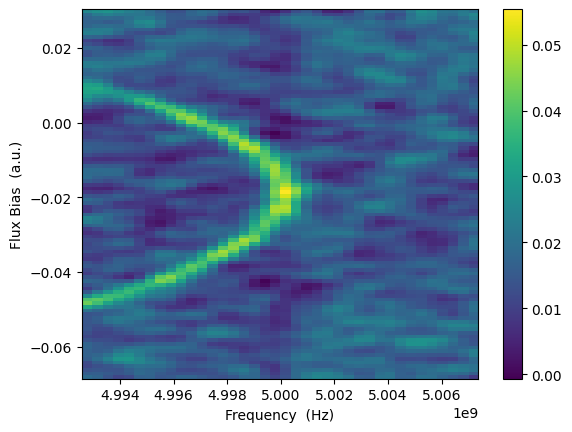

In [54]:
# plotting the filtered data with zca + gaussian filter
plot_function(s_masked, unique_freq, unique_bias)

Sclice-scaling aims to compensate for variations in signal amplitude across the sweep, ensuring that peaks can be detected consistently even when their absolute strength changes with flux bias values.

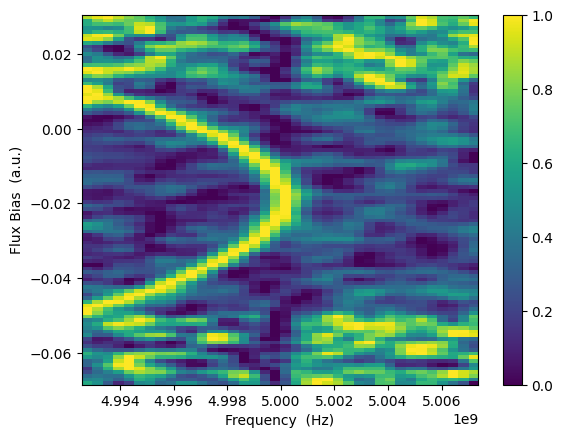

In [56]:
# plotting slice-scaled data
plot_function(s_masked_norm, unique_freq, unique_bias)

# 2. Peak Detection

After preprocessing, the method identifies candidate signal points by analyzing each horizontal slice independently. For a fixed value of y, the corresponding one-dimensional signal as a function of x is extracted and analyzed using a peak-finding algorithm. Depending on the value of the find_min flag, the algorithm searches either for maxima or for minima. A minimum prominence threshold is imposed so that only peaks that clearly stand out from the local background are considered, which prevents noise-induced fluctuations from being misidentified as signal.

In cases where multiple peaks are detected within the same slice, only the most prominent one is retained. This choice enforces the assumption that, at a given value of y, the physical signal is represented by a single dominant feature. As a result, the two-dimensional signal is reduced to a sparse set of candidate points, with at most one point per horizontal slice.

The positions of these points are stored both as grid indices and as physical values of x and y. At this stage, the original image-like dataset has been transformed into a cloud of points that trace all possible signal-like structures present in the data.

In [ ]:
def clustering(data: tuple, min_points_per_cluster: int) -> list[bool]:
    """Divides the processed signal into clusters for separating signal from noise.

    In this function Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN) algorithm is used;
    HDBSCAN good for successfully capture clusters with different densities.

    `data_dict` is a 3D tuple of the data to cluster, while `min_points_per_cluster` is the minimum size of points for a cluster to be considered relevant signal.
    It allows a `min_cluster_size=2` in order to decrease as much as possible misclassification of few points.
    The function returns a boolean list corresponding to the indices of the relevant signal.
    """

    hdb = HDBSCAN(copy=True, min_cluster_size=2, cluster_selection_epsilon=5.0)

    peaks_vals = data[2]
    X = np.stack(data).T
    hdb.fit(X)
    hdb.labels_.shape == (X.shape[0],)
    labels = hdb.labels_

    clusters = np.unique(labels)
    valid_clusters = [
        c for c in clusters if np.sum(labels == c) >= min_points_per_cluster
    ]
    # since we allowed for clustering even a group of 2 points, we filter the allowed eligible clusters
    # to be at least composed by a minimum number of points given by min_points_per_cluster parameter

    medians = [np.median(peaks_vals[labels == c]) for c in valid_clusters]
    if len(medians) == 0:
        return [False] * len(labels)

    signal = valid_clusters[np.argmax(medians)]
    # in general the true signal has the highest magnitude across the whoole dataset, so we distinguish
    # if from background noise by selecting the cluster with the highest median of the signal

    return labels == signal


def scaling(sig: np.ndarray) -> np.ndarray:
    sig_min = np.min(sig)
    return (sig - sig_min) / (np.max(sig) - sig_min)


def horizontal_diagonal(xs: np.ndarray, ys: np.ndarray) -> float:
    sizes = np.empty(2)
    for i, values in enumerate([xs, ys]):
        sizes[i] = np.max(values) - np.min(values)
    return np.sqrt((sizes**2).sum())


def build_clustering_data(peaks_dict: dict, z: np.ndarray):
    peaks_x = peaks_dict["x"]["idx"]
    peaks_y = peaks_dict["y"]["idx"]
    peaks_sf = z[peaks_y, peaks_x]

    diag = horizontal_diagonal(peaks_x, peaks_y)
    diag = np.sqrt(2)
    return (peaks_x, peaks_y, scaling(peaks_sf) * diag)


def peaks_finder(x, y, z, find_min) -> dict:
    # filter data using find_peaks
    peaks = {"x": {"idx": [], "val": []}, "y": {"idx": [], "val": []}}
    for y_idx, y_val in enumerate(y):
        signal_fixed_y = z[y_idx]
        peak, info = find_peaks(
            -signal_fixed_y if find_min else signal_fixed_y, prominence=0.2
        )
        if len(peak) > 0:
            idx = np.argmax(info["prominences"])
            # if multiple peaks per bias are found, select the one with the highest prominence
            x_idx = peak[idx]
            peaks["x"]["idx"].append(x_idx)
            peaks["x"]["val"].append(x[x_idx])
            peaks["y"]["idx"].append(y_idx)
            peaks["y"]["val"].append(y_val)

    peaks_dict = {
        feat: {kind: np.array(vals) for kind, vals in smth.items()}
        for feat, smth in peaks.items()
    }

    return peaks_dict

In [24]:
def extract_feature(
    x: np.ndarray,
    y: np.ndarray,
    z: np.ndarray,
    find_min: bool,
    clustering_flag: bool,
    min_points: int = 5,
) -> tuple[np.ndarray, np.ndarray]:
    """Extract features of the signal by filtering out background noise.

    It first applies a custom filter mask (see `custom_filter_mask`)
    and then finds the biggest peak for each DC bias value;
    the masked signal is then clustered (see `clustering`) in order to classify the relevant signal for the experiment.
    If `find_min` is set to `True` it finds minimum peaks of the input signal;
    `min_points` is the minimum number of points for a cluster to be considered relevant signal.
    Position of the relevant signal is returned.
    """

    x_ = np.unique(x)
    y_ = np.unique(y)
    # background removed over y axis
    z_ = z.reshape(len(y_), len(x_))

    # masking
    z_masked = custom_filter_mask(z_)

    # renormalizing
    # z_masked_norm = scaling_signal(z_masked)
    z_masked_norm = scaling_slice(z_masked)

    # filter data using find_peaks
    peaks_dict = peaks_finder(x_, y_, z_masked_norm, find_min)

    if clustering_flag:
        # normalizing peaks for clustering
        clustering_tuple = build_clustering_data(peaks_dict, z_masked)

        # clustering
        signal_classification = clustering(clustering_tuple, min_points)
        new_peaks_dict = {
            feat: {
                kind: np.array(vals)[signal_classification]
                for kind, vals in smth.items()
            }
            for feat, smth in peaks_dict.items()
        }
    else:
        new_peaks_dict = peaks_dict

    return new_peaks_dict, z_masked


# def extract_feature_old(
#     x: np.ndarray, y: np.ndarray, z: np.ndarray, find_min: bool) -> tuple[np.ndarray, np.ndarray]:
#     """Extract features of the signal by filtering out background noise.

#     It first applies a custom filter mask (see `custom_filter_mask`)
#     and then finds the biggest peak for each DC bias value;
#     the masked signal is then clustered (see `clustering`) in order to classify the relevant signal for the experiment.
#     If `find_min` is set to `True` it finds minimum peaks of the input signal;
#     `min_points` is the minimum number of points for a cluster to be considered relevant signal.
#     Position of the relevant signal is returned.
#     """

#     x_ = np.unique(x)
#     y_ = np.unique(y)
#     # background removed over y axis
#     z_masked = z.reshape(len(y_), len(x_))
#     z_min = np.min(z_masked, axis=1)
#     z_masked_norm = ((z_masked.T - z_min) / (np.max(z_masked, axis=1) - z_min)).T

#     # filter data using find_peaks
#     peaks = {"x": {"idx": [], "val": []}, "y": {"idx": [], "val": []}}
#     for y_idx, y_val in enumerate(y_):
#         signal_fixed_y = z_masked_norm[y_idx]
#         peak, info = find_peaks(
#             -signal_fixed_y if find_min else signal_fixed_y, prominence=0.2
#         )
#         if len(peak) > 0:
#             idx = np.argmax(info["prominences"])
#             # if multiple peaks per bias are found, select the one with the highest prominence
#             x_idx = peak[idx]
#             peaks["x"]["idx"].append(x_idx)
#             peaks["x"]["val"].append(x_[x_idx])
#             peaks["y"]["idx"].append(y_idx)
#             peaks["y"]["val"].append(y_val)

#     peaks_dict = {
#         feat: {kind: np.array(vals) for kind, vals in smth.items()}
#         for feat, smth in peaks.items()
#     }

#     return peaks_dict, z_masked

In [25]:
def extract_and_plot(
    _signal,
    _freq,
    _bias,
    find_min_flag: bool = False,
    clustering_flag: bool = False,
    min_cluster_points: int = 5,
):
    _peaks, _sig = extract_feature(
        _freq, _bias, _signal, find_min_flag, clustering_flag, min_cluster_points
    )

    _freq_points = _peaks["x"]["val"]
    _bias_points = _peaks["y"]["val"]

    plt.imshow(
        _sig.T,
        origin="lower",
        aspect="auto",
        extent=[_bias.min(), _bias.max(), _freq.min(), _freq.max()],
    )
    plt.colorbar()

    plt.scatter(_bias_points, _freq_points, c="r", lw=1, ec="k", s=20)

    return _peaks, _sig

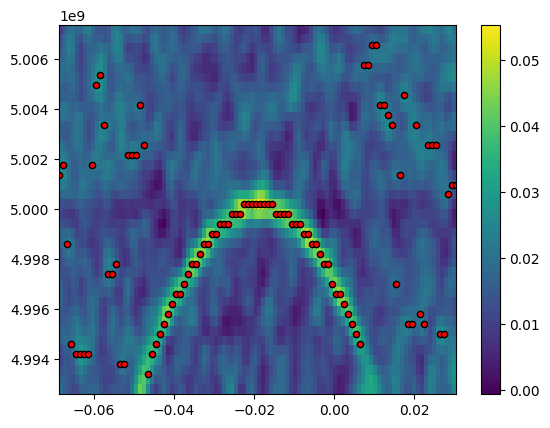

In [26]:
results, sg = extract_and_plot(
    s, f, b, find_min_flag=find_min_peak, clustering_flag=False, min_cluster_points=5
)

In [103]:
np.stack((results["x"]["idx"], results["y"]["idx"])).T

array([[10,  0],
       [10,  1],
       [10,  2],
       [11,  3],
       [11,  4],
       [11,  5],
       [11,  6],
       [11,  7],
       [11,  8],
       [11,  9],
       [11, 10],
       [12, 11],
       [12, 12],
       [12, 13],
       [12, 14],
       [12, 15],
       [12, 16],
       [12, 17],
       [13, 18],
       [13, 19],
       [13, 20],
       [13, 21],
       [13, 22],
       [14, 23],
       [14, 24],
       [14, 25],
       [14, 26],
       [14, 27],
       [15, 28],
       [15, 29],
       [15, 30],
       [15, 31],
       [16, 32],
       [16, 33],
       [16, 34],
       [16, 35],
       [17, 36],
       [17, 37],
       [17, 38],
       [17, 39],
       [18, 40],
       [18, 41],
       [18, 42],
       [18, 43],
       [18, 44],
       [19, 45],
       [19, 46],
       [19, 47],
       [19, 48],
       [19, 49],
       [19, 50],
       [19, 51],
       [19, 52],
       [19, 53],
       [19, 54],
       [19, 55],
       [19, 56],
       [18, 57],
       [18, 58

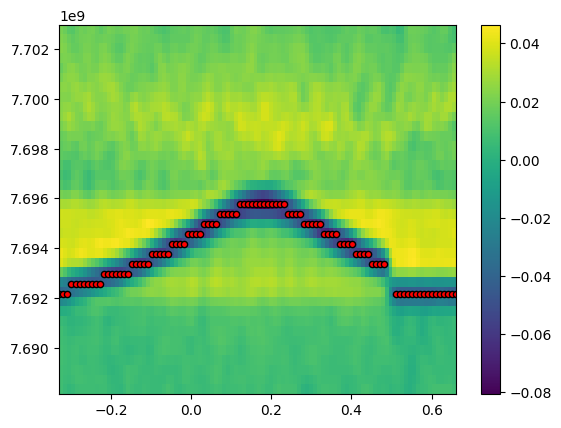

In [104]:
extract_and_plot(
    s, f, b, find_min_flag=find_min_peak, clustering_flag=True, min_cluster_points=5
);

In [128]:
# zca = zca_whiten(s)
# zca_sg = ndimage.gaussian_filter(zca, 1)
# results = extract_and_plot(zca_sg, f, b, find_min_flag=True, min_cluster_points=5, old_flag=True);

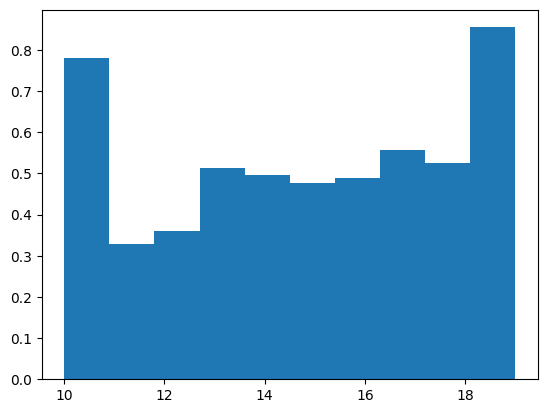

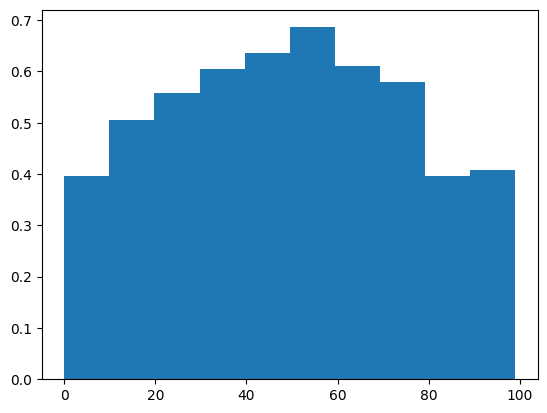

In [129]:
peaks_vals = results["x"]["val"]
# unique_values, counts = np.unique(arr, return_counts=True)
peaks_x = results["x"]["idx"]
peaks_y = results["y"]["idx"]
peaks_sf = (-1) ** find_min_peak * sg[peaks_y, peaks_x]
plt.figure(0)
plt.hist(peaks_x, weights=peaks_sf)
plt.figure(1)
plt.hist(peaks_y, weights=peaks_sf);

<IPython.core.display.Javascript object>


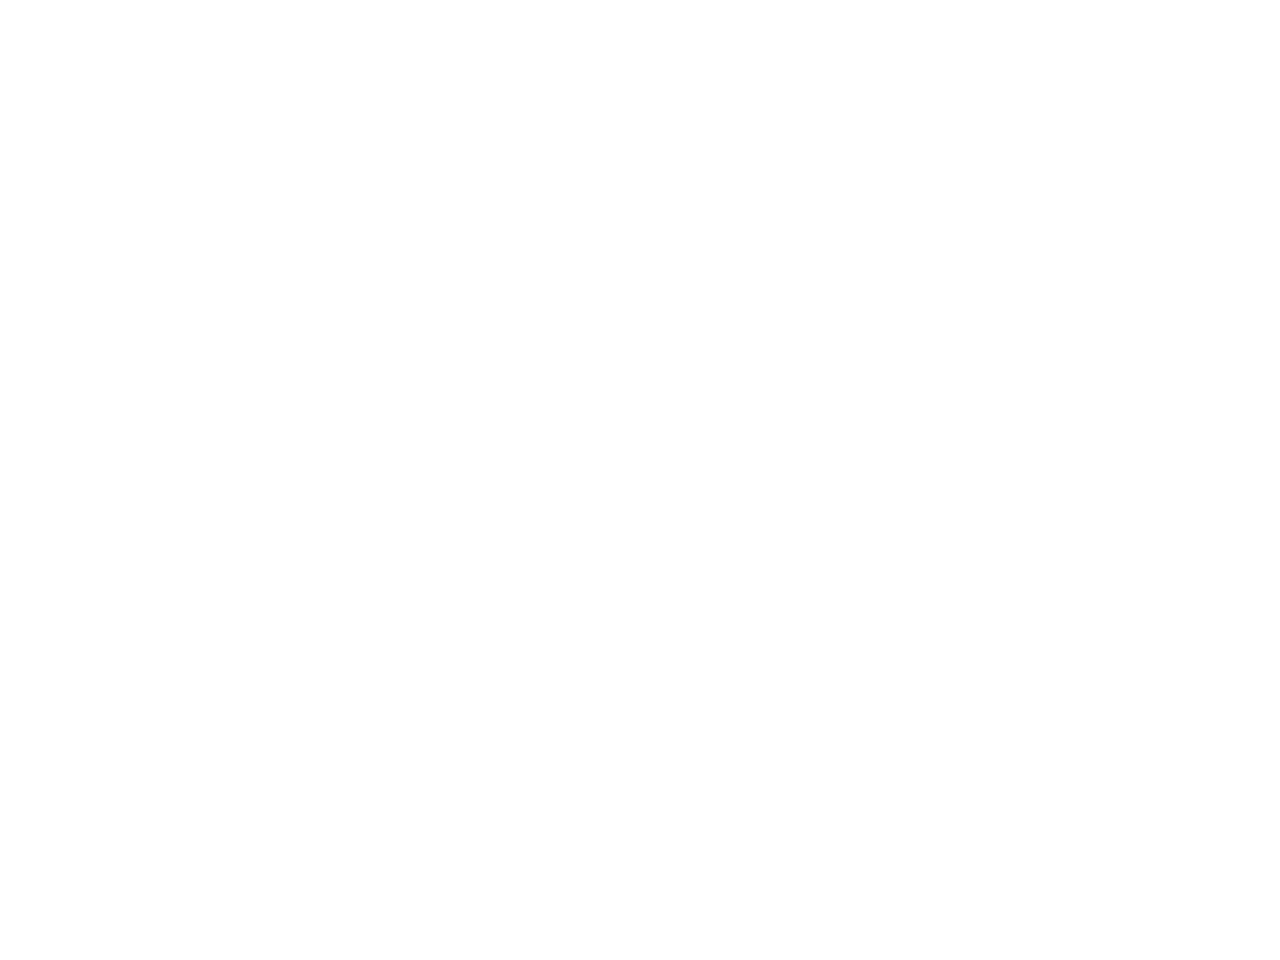

<IPython.core.display.Javascript object>


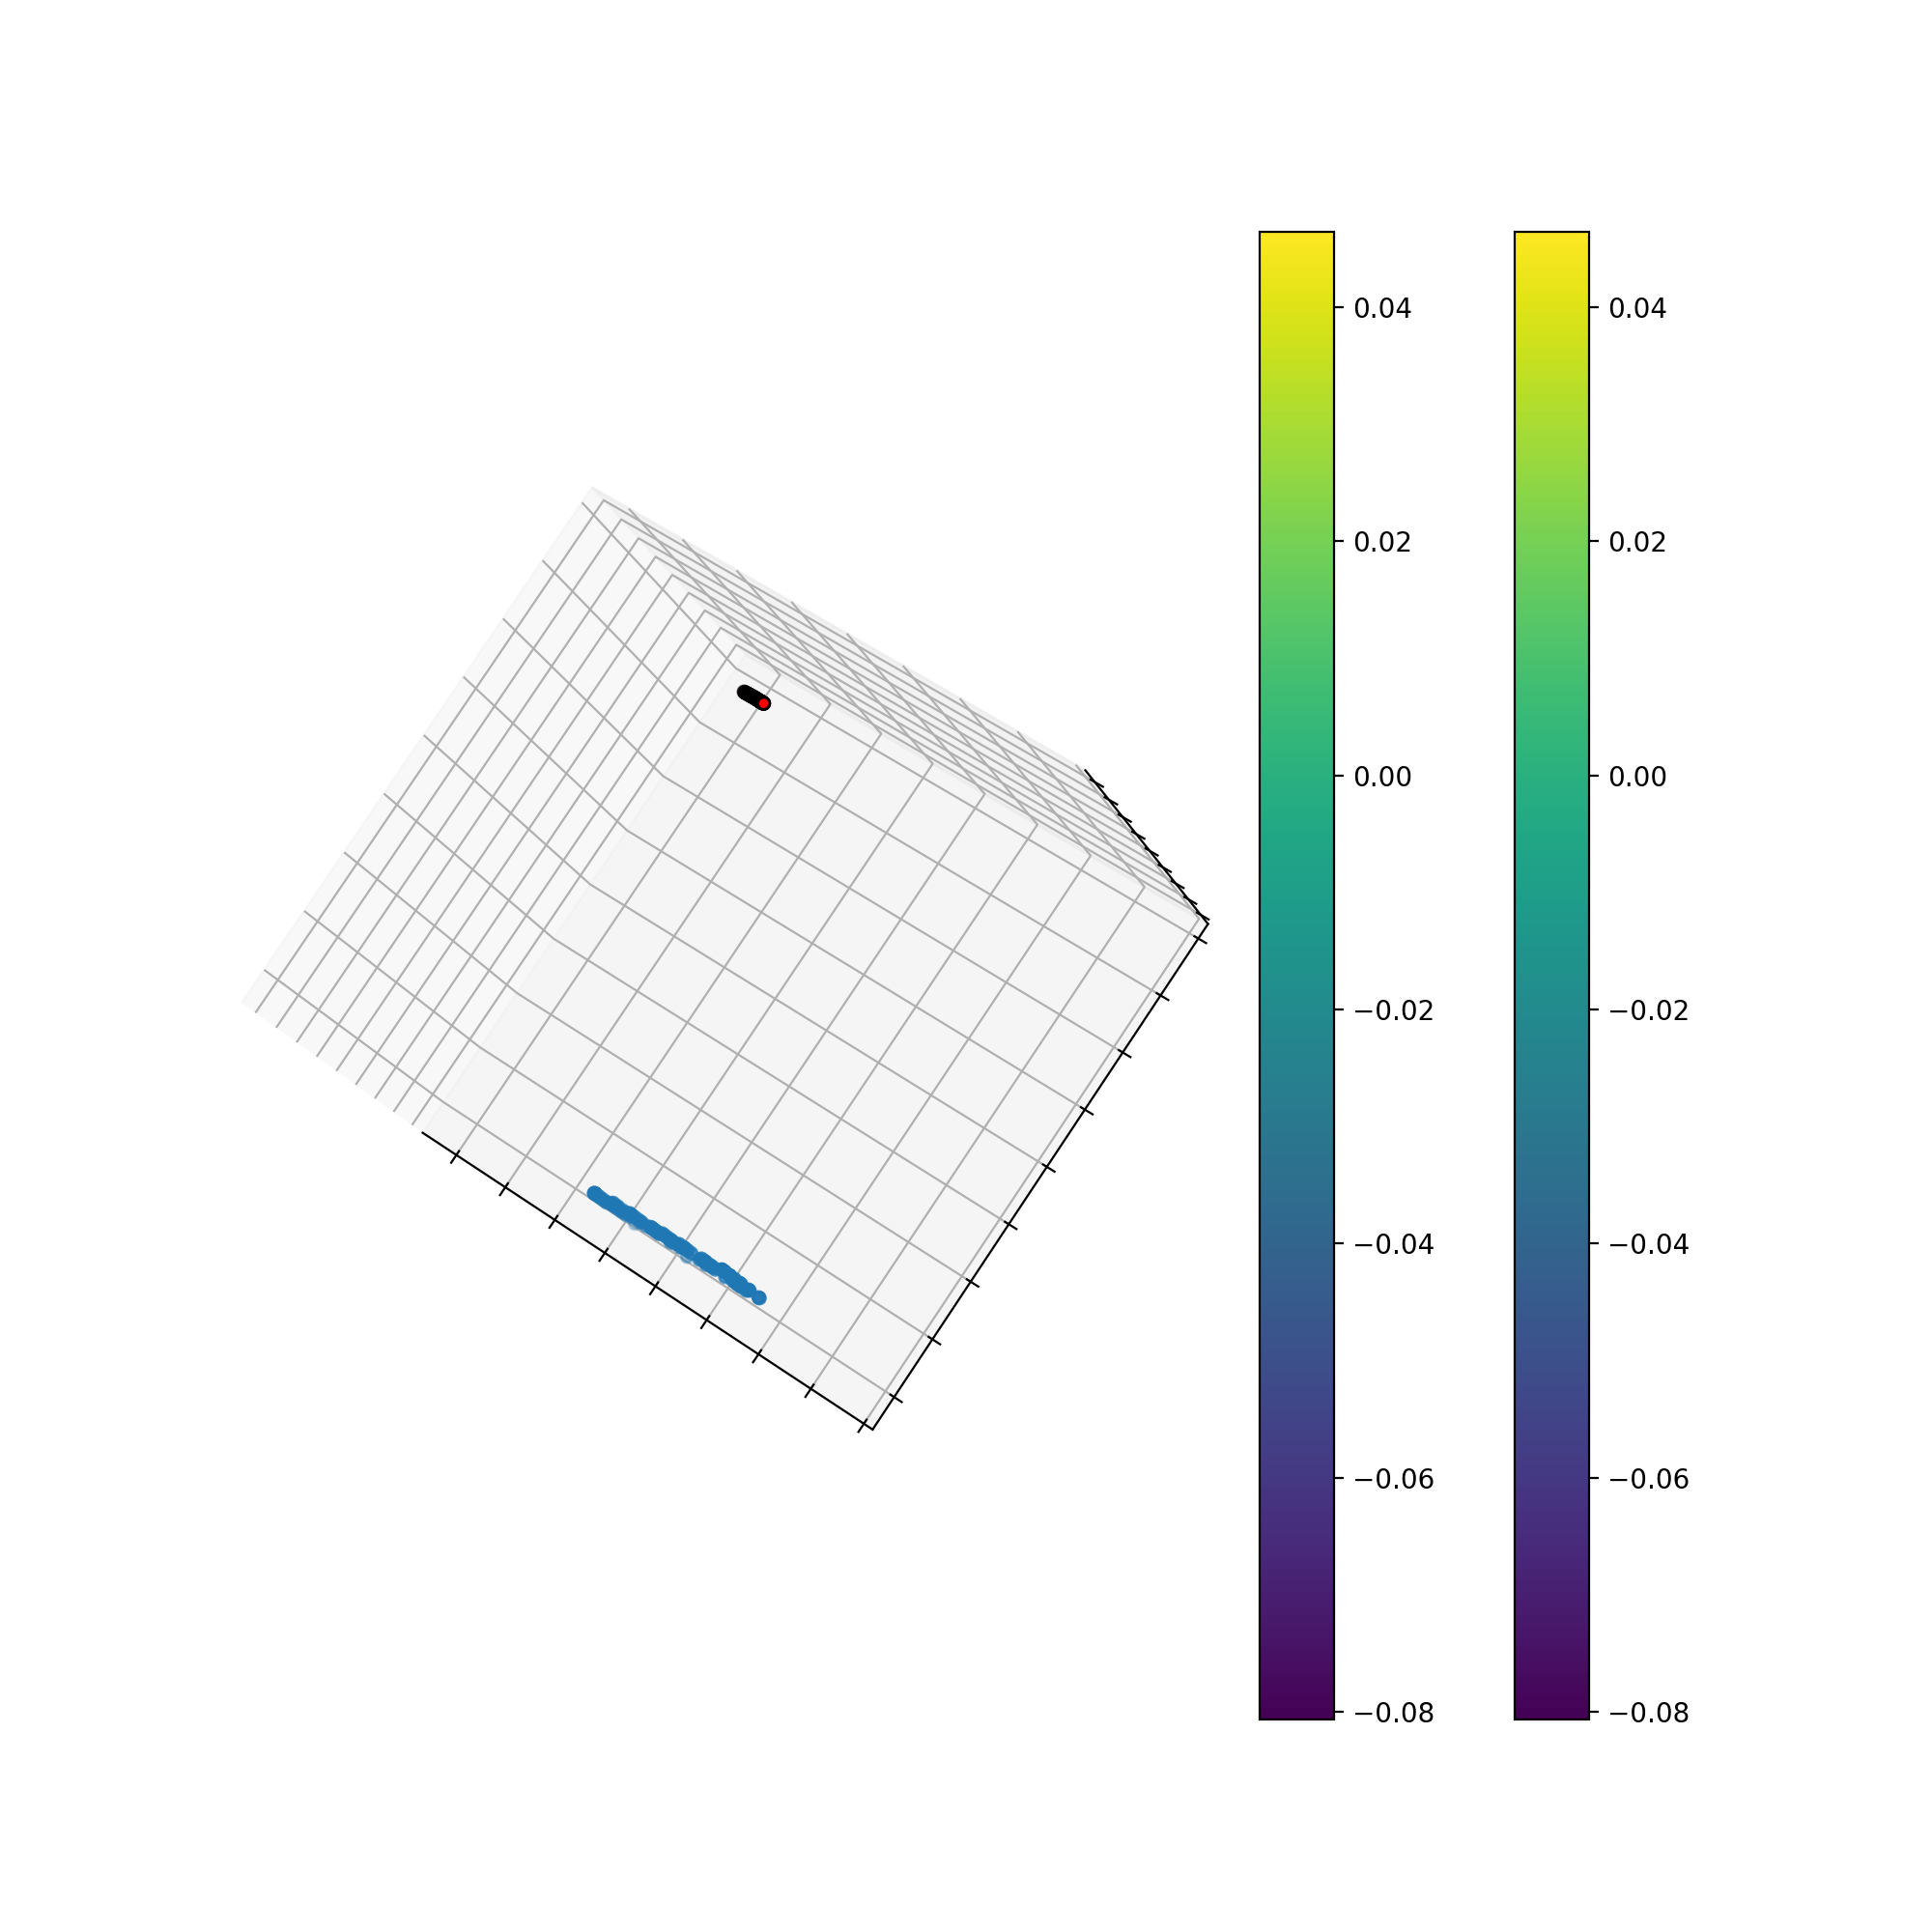

In [ ]:
# %matplotlib nbagg
plt.clf()
# plt.style.use('_mpl-gallery')

# Make data
X = np.arange(sg.shape[1])
Y = np.arange(sg.shape[0])
X, Y = np.meshgrid(X, Y)
Z = sg

# Plot the surface
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={"projection": "3d"})
# ax.plot_surface(X, Y, Z, vmin=Z.min() * 2, cmap="magma")
ax.scatter(peaks_x, peaks_y, peaks_sf)

ax.set(xticklabels=[], yticklabels=[], zticklabels=[])

plt.show()

/tmp/ipykernel_10754/2930591610.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(peaks_y[s_], peaks_x[s_], c="r", cmap="tab10", lw=1, ec="k");


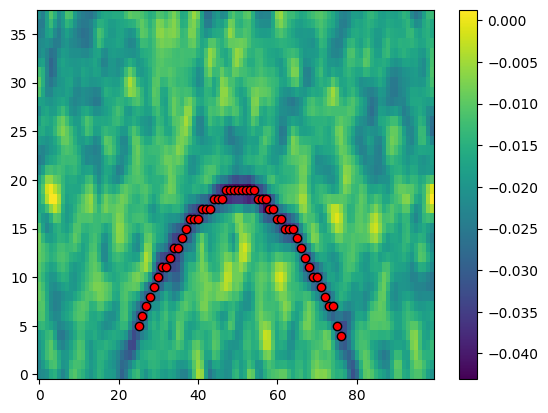

In [ ]:
# hdb = HDBSCAN(copy=True, min_cluster_size=10)
# X = np.stack((peaks_x, peaks_y, peaks_sf)).T
# hdb.fit(X)
# hdb.labels_.shape == (X.shape[0],)
# labels = hdb.labels_

# clusters = np.unique(labels)
# medians = [np.median(peaks_sf[labels == c]) for c in clusters]
# signal = clusters[np.argmax(medians)]

# plt.imshow(zca_sg.T, origin="lower", aspect="auto")
# plt.colorbar()

# s_ = labels == signal
# plt.scatter(peaks_y[s_], peaks_x[s_], c="r", cmap="tab10", lw=1, ec="k");